<a href="https://colab.research.google.com/github/RegNLP/ReguSum/blob/main/ReguSum_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ===== Step 1: Fetch CSV files from Google Drive (DocumentsInfo) =====
# What this cell does:
#  - installs gdown + pandas
#  - (optionally) mounts your Google Drive
#  - downloads the shared "DocumentsInfo" folder via gdown
#  - lists and previews the CSV files we just fetched

# --- Config ---
FOLDER_ID = "1hDL5CCE89Qg4ajMXfUGxlPEY6cFBa--N"  # from your shared link
DEST_DIR  = "/content/data/DocumentsInfo"        # local folder to hold the CSVs


# --- Install deps ---
!pip -q install gdown pandas

import os, glob, shutil, textwrap
from pathlib import Path
import pandas as pd


# --- Make destination directory ---
Path(DEST_DIR).mkdir(parents=True, exist_ok=True)

# --- Download the folder via gdown ---
print("Downloading 'DocumentsInfo' from Google Drive...")
!gdown --folder "https://drive.google.com/drive/folders/{FOLDER_ID}" -O {DEST_DIR}

# --- Verify: list CSV files ---
csv_paths = sorted(glob.glob(os.path.join(DEST_DIR, "*.csv")))
print(f"\nFound {len(csv_paths)} CSV file(s) in {DEST_DIR}:\n")
for p in csv_paths[:10]:
    print(" -", os.path.basename(p))
if len(csv_paths) > 10:
    print(f" ... and {len(csv_paths)-10} more.")

# --- Quick sanity preview: show first 2 rows + columns for up to 3 CSVs ---
def preview_csv(path, n=2):
    try:
        df = pd.read_csv(path, dtype=str, keep_default_na=False)
        #print("\n=== Preview:", os.path.basename(path), "===")
        #print("Columns:", list(df.columns))
        #display(df.head(n))
    except Exception as e:
        print(f"[warn] Could not read {os.path.basename(path)}: {e}")

for p in csv_paths[:3]:
    preview_csv(p, n=2)



Retrieving folder contents
Processing file 1UUdNdznSMe8YIyh4SxwaiqCwM6tFZJN9 m6g-oqrn-vuxf.csv
Processing file 1VC9css9H1lHCS_H8rDeHxu7M4J9SaUcw m6i-1gtx-mmls.csv
Processing file 1bxlvaN07RIUd6GwYF7SJCpd1xnVyJR8j m6i-1jxq-2dx1.csv
Processing file 1P7XXUYQAcEaHGl-1Sw4oWwQ8EwKkVTSu m6i-1lz5-v9ud.csv
Processing file 1IND51zFqJdHXCi2HEnuVwwm6z0Lz4-GJ m6i-1pux-9azw.csv
Processing file 14JTtvX7Q8X8h2VPXgCNbS-8S7yX4VGhr m6i-1sj5-t1tn.csv
Processing file 1UCX0tI0gfriQnqXfJ7XTrTEh6-znBa7l m6i-1tht-4u4x.csv
Processing file 17lxQwqeqSp0XKC5geMkfPJRI40rs1DCn m6i-1un0-8mu9.csv
Processing file 1Md7OIWzEm8HL7IoNzxSYkacs9j509R5e m6i-1vl3-nybo.csv
Processing file 1QodqHz3sGPHpWSHrLS__QJ4iWvWUheVk m6i-1wpl-dukq.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1UUdNdznSMe8YIyh4SxwaiqCwM6tFZJN9
To: /content/data/DocumentsInfo/m6g-oqrn-vuxf.csv
100% 28.5k/28.5k [00:00<00:00, 58.4MB/s]
Downloading

In [5]:
# ===== Step 2 (HTM-only with DocumentID filenames): Parse CSVs and download .htm files =====
import os, re, glob
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import requests

DOCINFO_DIR = Path("/content/data/DocumentsInfo")
HTML_DIR    = Path("/content/data/DocumentsHTML")
HTML_DIR.mkdir(parents=True, exist_ok=True)

# --- Split CSV cell values by commas/semicolons/whitespace ---
SPLIT_RE = re.compile(r'[,\s;]+', re.IGNORECASE)

def extract_htm_urls(cell_value: str):
    """
    From a 'Content Files' cell like:
      "https://.../IRS-2008-0053-0009/content.pdf,https://.../IRS-2008-0053-0009/content.htm"
    return ONLY the .htm/.html URLs.
    """
    if pd.isna(cell_value):
        return []
    parts = [p.strip().rstrip(').,;\'"') for p in SPLIT_RE.split(str(cell_value).strip()) if p.strip()]
    return [u for u in parts if re.search(r'\.(htm|html)(\?|#|$)', u, re.IGNORECASE)]

def pick_content_column(df: pd.DataFrame):
    if "Content Files" in df.columns:
        return "Content Files"
    for c in df.columns:
        lc = c.lower()
        if "content" in lc and "file" in lc:
            return c
    return None

# HTTP session with browser-like UA
SESSION = requests.Session()
SESSION.headers.update({
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0 Safari/537.36"
})

def fetch_htm(url: str, dest_dir: Path) -> Path | None:
    """
    Download .htm/.html file and save as <DocumentID>.htm
    Example URL: https://downloads.regulations.gov/IRS-2016-0007-0010/content.htm
    Saved file: IRS-2016-0007-0010.htm
    """
    try:
        # extract DocumentID from URL (the part before /content)
        m = re.search(r'/([A-Z]+-\d{4}-\d+-\d+)/content', url)
        if not m:
            print(f"[warn] Could not parse DocumentID from {url}")
            return None
        doc_id = m.group(1)
        filename = f"{doc_id}.htm"
        out_path = dest_dir / filename

        if out_path.exists() and out_path.stat().st_size > 0:
            return out_path

        r = SESSION.get(url, timeout=30, allow_redirects=True)
        if r.status_code != 200:
            print(f"[warn] {r.status_code} for {url}")
            return None
        out_path.write_bytes(r.content)
        return out_path
    except Exception as e:
        print(f"[warn] Download failed {url}: {e}")
        return None

# --- Parse all CSVs ---
csv_paths = sorted(glob.glob(str(DOCINFO_DIR / "*.csv")))
if not csv_paths:
    raise RuntimeError(f"No CSV files found under {DOCINFO_DIR.resolve()} — run Step 1 first.")

all_htm_urls = []
for csv_path in csv_paths:
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    col = pick_content_column(df)
    if not col:
        print(f"[skip] No 'Content Files' column in {os.path.basename(csv_path)}")
        continue
    for cell in df[col]:
        all_htm_urls.extend(extract_htm_urls(cell))

# dedup
seen = set()
unique_htm_urls = [u for u in all_htm_urls if not (u in seen or seen.add(u))]
print(f"Discovered {len(unique_htm_urls)} unique .htm URLs.")

# --- Download all ---
saved_paths = []
for url in tqdm(unique_htm_urls, desc="Downloading .htm files"):
    p = fetch_htm(url, HTML_DIR)
    if p:
        saved_paths.append(p)

# --- Summary ---
print(f"\nSaved {len(saved_paths)} HTM files to: {HTML_DIR.resolve()}")
if saved_paths[:5]:
    print("Examples:")
    for p in saved_paths[:5]:
        print(" -", p.name)


Discovered 379 unique .htm URLs.


[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2179/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2208/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2209/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2211/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2248/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2267/content.htm


[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-1901/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-1903/content.htm


[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2092/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2097/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2112/content.htm


[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2035/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2037/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2038/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2039/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2040/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2041/content.htm
[warn] Could not parse DocumentID from https://downloads.regulations.gov/IRS_FRDOC_0001-2048/content.htm



Saved 361 HTM files to: /content/data/DocumentsHTML
Examples:
 - IRS-2014-0030-0004.htm
 - IRS-2016-0007-0010.htm
 - IRS-2016-0010-0035.htm
 - IRS-2016-0044-0011.htm
 - IRS-2018-0027-0010.htm


In [6]:
# ===== Step 3 (updated): Parse .htm files -> regusum_dataset.json =====
import os, re, json
from pathlib import Path
from bs4 import BeautifulSoup

HTML_FOLDER_PATH   = "/content/data/DocumentsHTML"
OUTPUT_JSON_PATH   = "/content/data/regusum_dataset.json"

MIN_SECTION_LENGTH = 100

def segment_content(main_content):
    if not main_content:
        return []
    sections = []
    major_parts = re.split(
        r'\n(?=I\. |II\. |III\. |IV\. |V\. |VI\. |VII\. |VIII\. |IX\. |X\. |SUMMARY:|DATES:|FOR FURTHER INFORMATION CONTACT:)',
        main_content
    )
    major_parts = [part.strip() for part in major_parts if part and part.strip()]
    if len(major_parts) > 1:
        for part in major_parts:
            lines = part.split('\n')
            header, text = lines[0].strip(), '\n'.join(lines[1:]).strip()
            if len(header) < 200 and text:
                sections.append({"header": header, "text": text})
            else:
                if sections:
                    sections[-1]['text'] += '\n\n' + part
                else:
                    sections.append({"header": "Introduction", "text": part})
    else:
        sections.append({"header": "Main Content", "text": main_content})
    final_sections, temp_text_buffer = [], ""
    for section in reversed(sections):
        if len(section['text']) < MIN_SECTION_LENGTH and final_sections:
            temp_text_buffer = section['header'] + '\n\n' + section['text'] + '\n\n' + temp_text_buffer
        else:
            section['text'] += ('\n\n' + temp_text_buffer) if temp_text_buffer else ''
            final_sections.append(section)
            temp_text_buffer = ""
    if temp_text_buffer and final_sections:
        final_sections[-1]['text'] = temp_text_buffer + final_sections[-1]['text']
    return list(reversed(final_sections))

def extract_text_from_html(file_path):
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
            soup = BeautifulSoup(file, "html.parser")
        pre_tag = soup.find("pre")
        return (pre_tag.get_text("\n\n") if pre_tag else soup.get_text("\n\n")), soup
    except Exception as e:
        print(f"Error reading {os.path.basename(file_path)}: {e}")
        return None, None

def extract_title(soup):
    return soup.title.string.strip() if soup and soup.title and soup.title.string else "Title Not Found"

def parse_regulation_file(file_path):
    doc_id = os.path.splitext(os.path.basename(file_path))[0]
    try:
        full_text, soup = extract_text_from_html(file_path)
        if not full_text:
            return None
        summary_match = re.search(
            r"SUMMARY:(.*?)(?=SUPPLEMENTARY INFORMATION:|FOR FURTHER INFORMATION CONTACT:)",
            full_text,
            re.DOTALL | re.IGNORECASE
        )
        if not summary_match:
            return None
        gold_summary = summary_match.group(1).strip()
        if not gold_summary:   # <<< NEW: ignore if summary is empty
            return None
        content_match = re.search(r"SUPPLEMENTARY INFORMATION:", full_text, re.IGNORECASE)
        main_content = full_text[content_match.end():].strip() if content_match else full_text
        sections = segment_content(main_content) or [{"header": "Main Content", "text": main_content}]
        title = extract_title(soup)
        agency_id = doc_id.split('-')[0] if '-' in doc_id else "UNKNOWN"
        topics_match = re.search(
            r"List of Subjects in.*?PART \d+(.*?)(?:Correction of Publication|Accordingly|PART)",
            full_text, re.DOTALL | re.IGNORECASE
        )
        topics = re.sub(r'\s+', ' ', topics_match.group(1).strip()).replace('\n', ',') if topics_match else "Topics Not Found"
        return {
            "ID": doc_id,
            "gold_summary": gold_summary,
            "Agency ID": agency_id,
            "Title": title,
            "Topics": topics,
            "original_content": main_content,
            "Sections": sections
        }
    except Exception as e:
        print(f"Could not process file {doc_id}. Error: {e}")
        return None

def create_dataset():
    all_documents = []
    html_files = sorted([f for f in os.listdir(HTML_FOLDER_PATH) if f.lower().endswith((".htm", ".html"))])
    print(f"Found {len(html_files)} HTM/HTML files to process.")
    for file_name in html_files:
        parsed = parse_regulation_file(os.path.join(HTML_FOLDER_PATH, file_name))
        if parsed and parsed.get("gold_summary"):   # safeguard check
            all_documents.append(parsed)
    if all_documents:
        with open(OUTPUT_JSON_PATH, "w", encoding="utf-8") as f:
            json.dump(all_documents, f, indent=2, ensure_ascii=False)
        print(f"[ok] Processed {len(all_documents)} documents.")
        print(f"[ok] Dataset saved -> {OUTPUT_JSON_PATH}")
    else:
        print("No valid documents were processed.")

create_dataset()


Found 361 HTM/HTML files to process.
[ok] Processed 345 documents.
[ok] Dataset saved -> /content/data/regusum_dataset.json


In [7]:
# ===== Step 4: Inspect the built dataset (IDs, Titles, Section headers) =====
import json, os
from pathlib import Path
import pandas as pd

# --- Options ---
USE_DRIVE_DATASET = False  # set True to use your Drive path below
DRIVE_DATASET_PATH = ""

# Default to the dataset built in Step 3:
LOCAL_DATASET_PATH = "/content/data/regusum_dataset.json"

# Where to write a compact overview CSV (optional)
OVERVIEW_CSV_PATH = "/content/data/regusum_dataset_overview.csv"

# --- Mount Drive only if needed ---
if USE_DRIVE_DATASET:
    from google.colab import drive
    drive.mount('/content/drive')

# --- Resolve path ---
DATASET_PATH = DRIVE_DATASET_PATH if USE_DRIVE_DATASET else LOCAL_DATASET_PATH
print(f"Using dataset: {DATASET_PATH}")

def inspect_all_documents(dataset_path: str, write_overview_csv: bool = True):
    """
    Loads the dataset and prints ID, Title, and section headers for each document.
    Also writes an overview CSV with basic stats per document (optional).
    """
    try:
        if not os.path.exists(dataset_path):
            print(f"Error: File not found at '{dataset_path}'")
            return

        with open(dataset_path, "r", encoding="utf-8") as f:
            dataset = json.load(f)

        if not dataset:
            print("The dataset is empty. Nothing to display.")
            return

        print("--- Document IDs and Section Headers ---")

        total_docs = 0
        docs_with_multiple_sections = 0
        total_sections = 0

        # For optional CSV overview
        overview_rows = []

        for document in dataset:
            total_docs += 1

            doc_id = document.get("ID", "ID Not Found")
            title = document.get("Title", "Title Not Found")
            sections = document.get("Sections", []) if isinstance(document.get("Sections", []), list) else []

            num_sections = len(sections)
            total_sections += num_sections
            if num_sections > 1:
                docs_with_multiple_sections += 1

            print(f"\nID: {doc_id}")
            print(f"Title: {title}")
            print(f"Sections Found: {num_sections}")

            headers = []
            if sections:
                for section in sections:
                    header = section.get("header", "Header Not Found")
                    headers.append(header)
                    print(f"  - Header: {header}")
            else:
                print("  - No sections found for this document.")

            overview_rows.append({
                "ID": doc_id,
                "Title": title,
                "NumSections": num_sections,
                "SectionHeaders": " | ".join(headers)
            })

        # --- Final Summary ---
        print("\n" + "="*40)
        print("--- Dataset Inspection Summary ---")
        print(f"Total Documents Processed: {total_docs}")
        print(f"Documents with Multiple Sections: {docs_with_multiple_sections}")
        if total_docs > 0:
            avg_sections = round(total_sections / total_docs, 2)
            print(f"Average Sections per Document: {avg_sections}")
        print("="*40)

        # Optional CSV
        if write_overview_csv:
            df = pd.DataFrame(overview_rows)
            Path(os.path.dirname(OVERVIEW_CSV_PATH)).mkdir(parents=True, exist_ok=True)
            df.to_csv(OVERVIEW_CSV_PATH, index=False)
            print(f"\n[ok] Wrote overview CSV -> {OVERVIEW_CSV_PATH}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the inspection
inspect_all_documents(DATASET_PATH, write_overview_csv=True)


Using dataset: /content/data/regusum_dataset.json
--- Document IDs and Section Headers ---

ID: IRS-2008-0041-0003
Title: Federal Register, Volume 85 Issue 113 (Thursday, June 11, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2008-0053-0009
Title: Federal Register, Volume 88 Issue 146 (Tuesday, August 1, 2023)
Sections Found: 1
  - Header: Main Content

ID: IRS-2008-0092-0007
Title: Federal Register, Volume 85 Issue 162 (Thursday, August 20, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2011-0050-0006
Title: Federal Register, Volume 85 Issue 46 (Monday, March 9, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2014-0001-0014
Title: Federal Register, Volume 85 Issue 88 (Wednesday, May 6, 2020)
Sections Found: 1
  - Header: Main Content

ID: IRS-2014-0030-0004
Title: Federal Register, Volume 89 Issue 231 (Monday, December 2, 2024)
Sections Found: 14
  - Header: Authority
  - Header: I. Overlapping Economic Risk of Loss
  - Header: II. Tiered Partnerships


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Loaded 345 documents.
[ok] Stats + distributions saved to /content/data

--- Aggregate Stats ---


/tmp/ipython-input-3452318741.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doc_dist = df.groupby(["Agency","DocLengthBin"]).size().unstack(fill_value=0)
/tmp/ipython-input-3452318741.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_dist = df.groupby(["Agency","SumLengthBin"]).size().unstack(fill_value=0)


,Agency,n_docs,avg_doc_words,avg_doc_sents,avg_sum_words,avg_sum_sents,avg_sections
0,IRS,205,26929.4,826.5,156.8,6.4,6.20
1,SEC,140,67379.7,1541.5,159.7,5.1,8.50
2,Total,345,43344.0,1116.6,158.0,5.9,7.11



--- Document Length Distribution ---


DocLengthBin,0-128,128-256,256-512,512-1024,1024-2048,2048-4096,4096-8192,8192+
Agency,,,,,,,,
IRS,1,23,17,21,10,14,23,96
SEC,2,6,5,3,8,20,12,84
Total,3,29,22,24,18,34,35,180



--- Summary Length Distribution ---


SumLengthBin,0-128,128-256,256-512,512-1024,1024-2048,2048-4096,4096-8192,8192+
Agency,,,,,,,,
IRS,110,77,13,4,1,0,0,0
SEC,68,54,17,1,0,0,0,0
Total,178,131,30,5,1,0,0,0


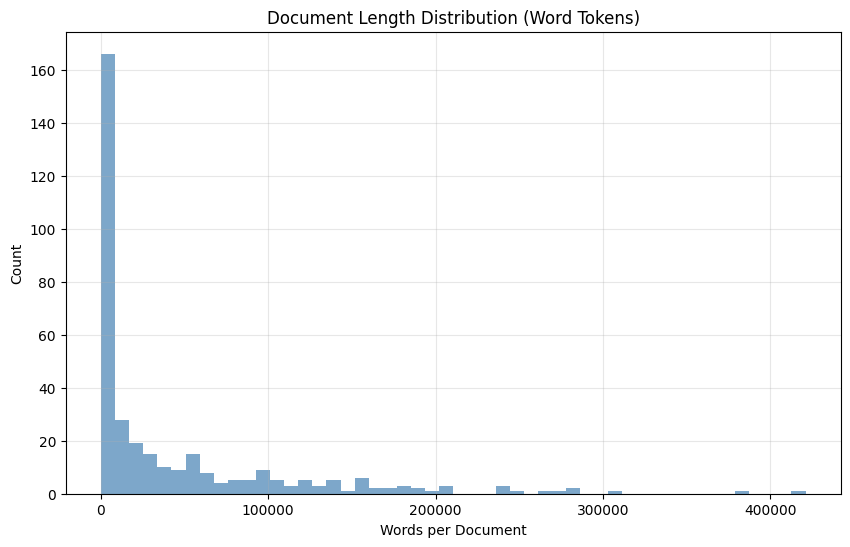

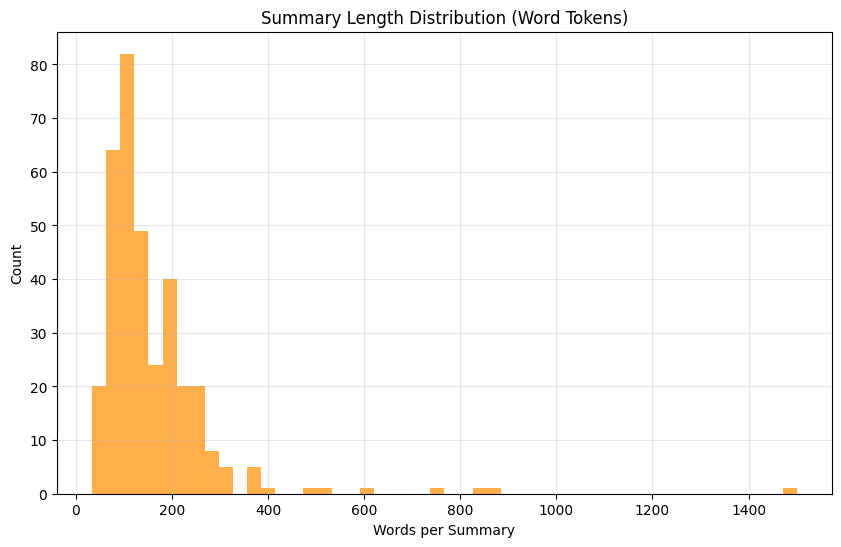

In [9]:
# ===== Step 4 (Unified with Plots): Full dataset statistics + histograms =====
import json, re
import pandas as pd
from pathlib import Path
import numpy as np
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt_tab')

# --- Setup ---
nltk.download("punkt", quiet=True)
from nltk.tokenize import sent_tokenize, word_tokenize

DATASET_PATH = "/content/data/regusum_dataset.json"
OUT_DIR = Path("/content/data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# File paths
STATS_CSV = OUT_DIR / "regusum_stats.csv"
STATS_MD  = OUT_DIR / "regusum_stats.md"
DOC_DIST_CSV = OUT_DIR / "regusum_doc_length_distribution.csv"
DOC_DIST_MD  = OUT_DIR / "regusum_doc_length_distribution.md"
SUM_DIST_CSV = OUT_DIR / "regusum_sum_length_distribution.csv"
SUM_DIST_MD  = OUT_DIR / "regusum_sum_length_distribution.md"

# --- Load dataset ---
with open(DATASET_PATH, "r", encoding="utf-8") as f:
    dataset = json.load(f)
print(f"Loaded {len(dataset)} documents.")

def count_words(text: str) -> int:
    return len(word_tokenize(text)) if text else 0

def count_sentences(text: str) -> int:
    return len(sent_tokenize(text)) if text else 0

# --- Build dataframe ---
rows = []
for doc in dataset:
    agency = doc.get("Agency ID", "UNKNOWN")
    doc_text = doc.get("original_content", "")
    sum_text = doc.get("gold_summary", "")
    rows.append({
        "ID": doc.get("ID", ""),
        "Agency": agency,
        "DocWords": count_words(doc_text),
        "DocSentences": count_sentences(doc_text),
        "SummaryWords": count_words(sum_text),
        "SummarySentences": count_sentences(sum_text),
        "NumSections": len(doc.get("Sections", []))
    })
df = pd.DataFrame(rows)

# --- Aggregate stats ---
agg = df.groupby("Agency").agg(
    n_docs=("ID", "count"),
    avg_doc_words=("DocWords", "mean"),
    avg_doc_sents=("DocSentences", "mean"),
    avg_sum_words=("SummaryWords", "mean"),
    avg_sum_sents=("SummarySentences", "mean"),
    avg_sections=("NumSections", "mean")
).reset_index()

for col in agg.columns:
    if col.startswith("avg_"):
        agg[col] = agg[col].round(1)

total = pd.DataFrame([{
    "Agency": "Total",
    "n_docs": df.shape[0],
    "avg_doc_words": df["DocWords"].mean().round(1),
    "avg_doc_sents": df["DocSentences"].mean().round(1),
    "avg_sum_words": df["SummaryWords"].mean().round(1),
    "avg_sum_sents": df["SummarySentences"].mean().round(1),
    "avg_sections": df["NumSections"].mean().round(2)
}])
stats_df = pd.concat([agg, total], ignore_index=True)

# --- Binned distributions ---
bins = [0,128,256,512,1024,2048,4096,8192,np.inf]
labels = ["0-128","128-256","256-512","512-1024","1024-2048","2048-4096","4096-8192","8192+"]

df["DocLengthBin"] = pd.cut(df["DocWords"], bins=bins, labels=labels, right=False)
df["SumLengthBin"] = pd.cut(df["SummaryWords"], bins=bins, labels=labels, right=False)

doc_dist = df.groupby(["Agency","DocLengthBin"]).size().unstack(fill_value=0)
doc_dist.loc["Total"] = doc_dist.sum()
sum_dist = df.groupby(["Agency","SumLengthBin"]).size().unstack(fill_value=0)
sum_dist.loc["Total"] = sum_dist.sum()

# --- Save ---
stats_df.to_csv(STATS_CSV, index=False)
with open(STATS_MD,"w",encoding="utf-8") as f: f.write(stats_df.to_markdown(index=False))
doc_dist.to_csv(DOC_DIST_CSV); sum_dist.to_csv(SUM_DIST_CSV)
with open(DOC_DIST_MD,"w",encoding="utf-8") as f: f.write(doc_dist.to_markdown())
with open(SUM_DIST_MD,"w",encoding="utf-8") as f: f.write(sum_dist.to_markdown())

print("[ok] Stats + distributions saved to /content/data")

# --- Display previews ---
print("\n--- Aggregate Stats ---"); display(stats_df)
print("\n--- Document Length Distribution ---"); display(doc_dist)
print("\n--- Summary Length Distribution ---"); display(sum_dist)

# --- Histograms ---
plt.figure(figsize=(10,6))
plt.hist(df["DocWords"], bins=50, color="steelblue", alpha=0.7)
plt.title("Document Length Distribution (Word Tokens)")
plt.xlabel("Words per Document")
plt.ylabel("Count")
plt.yscale("linear")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
plt.hist(df["SummaryWords"], bins=50, color="darkorange", alpha=0.7)
plt.title("Summary Length Distribution (Word Tokens)")
plt.xlabel("Words per Summary")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()


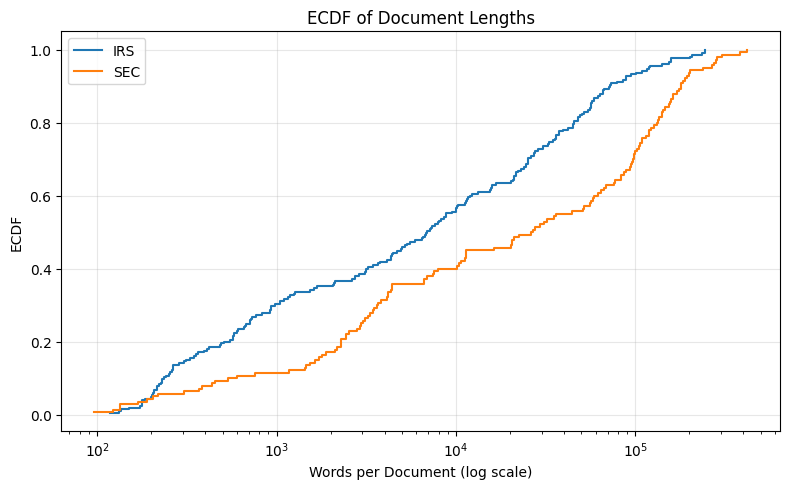

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/len(xs)
    return xs, ys

plt.figure(figsize=(8,5))
for agency, sub in df.groupby("Agency"):
    xs, ys = ecdf(sub["DocWords"])
    plt.step(xs, ys, where="post", label=f"{agency}")
plt.xscale("log")
plt.xlabel("Words per Document (log scale)")
plt.ylabel("ECDF")
plt.title("ECDF of Document Lengths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


/tmp/ipython-input-3863817317.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_docs, labels=agencies, showfliers=False)
/tmp/ipython-input-3863817317.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_sums, labels=agencies, showfliers=True)


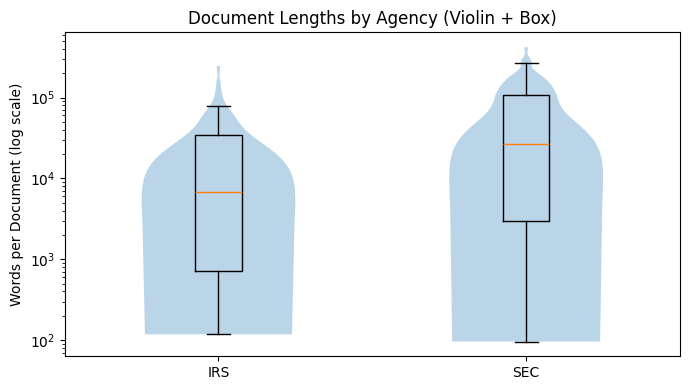

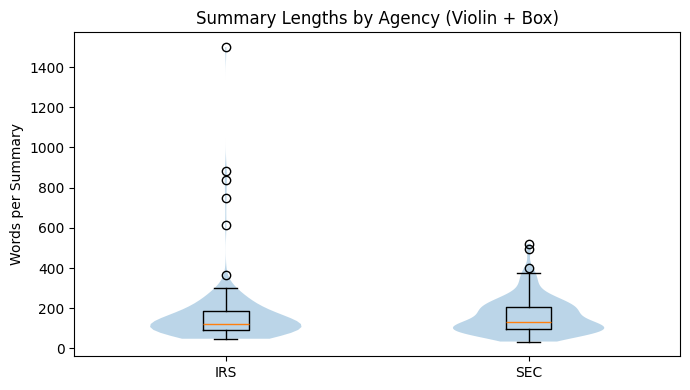

In [11]:
import matplotlib.pyplot as plt

agencies = list(df["Agency"].unique())
data_docs = [df.loc[df["Agency"]==a, "DocWords"].values for a in agencies]
data_sums = [df.loc[df["Agency"]==a, "SummaryWords"].values for a in agencies]

# Documents
plt.figure(figsize=(7,4))
plt.violinplot(data_docs, showmeans=False, showextrema=False)
plt.boxplot(data_docs, labels=agencies, showfliers=False)
plt.yscale("log")
plt.ylabel("Words per Document (log scale)")
plt.title("Document Lengths by Agency (Violin + Box)")
plt.tight_layout()

# Summaries
plt.figure(figsize=(7,4))
plt.violinplot(data_sums, showmeans=False, showextrema=False)
plt.boxplot(data_sums, labels=agencies, showfliers=True)
plt.ylabel("Words per Summary")
plt.title("Summary Lengths by Agency (Violin + Box)")
plt.tight_layout()


In [12]:
import pandas as pd
pct = [0.5, 0.75, 0.9, 0.95, 0.99]

def percentiles(series):
    return pd.Series(
        {f"P{int(p*100)}": series.quantile(p) for p in pct}
    )

doc_pct = df.groupby("Agency")["DocWords"].apply(percentiles).unstack(1)
sum_pct = df.groupby("Agency")["SummaryWords"].apply(percentiles).unstack(1)

print("Document length percentiles:")
display(doc_pct.round(0))
print("Summary length percentiles:")
display(sum_pct.round(0))


Document length percentiles:


,P50,P75,P90,P95,P99
Agency,,,,,
IRS,6861.0,34580.0,71897.0,118298.0,235573.0
SEC,26556.0,108663.0,179515.0,238989.0,353908.0


Summary length percentiles:


,P50,P75,P90,P95,P99
Agency,,,,,
IRS,120.0,184.0,248.0,281.0,834.0
SEC,134.0,207.0,262.0,328.0,457.0


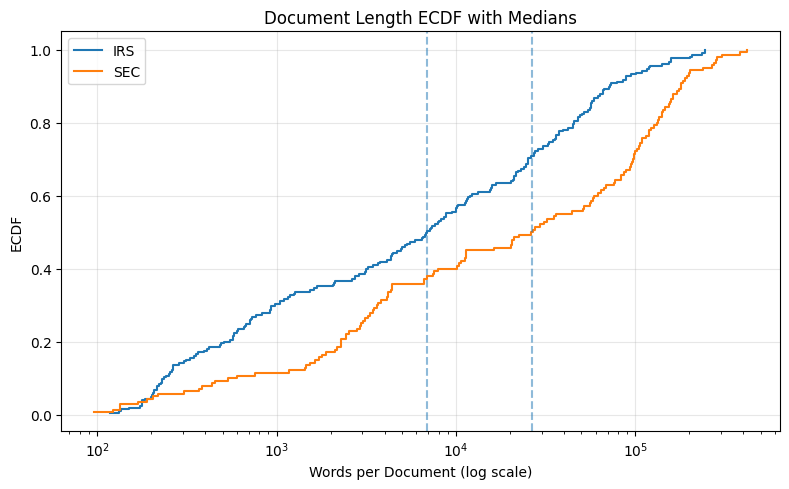

In [13]:
plt.figure(figsize=(8,5))
for agency, sub in df.groupby("Agency"):
    xs, ys = ecdf(sub["DocWords"])
    plt.step(xs, ys, where="post", label=f"{agency}")
    med = np.median(sub["DocWords"])
    plt.axvline(med, linestyle="--", alpha=0.5)
plt.xscale("log")
plt.xlabel("Words per Document (log scale)")
plt.ylabel("ECDF")
plt.title("Document Length ECDF with Medians")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


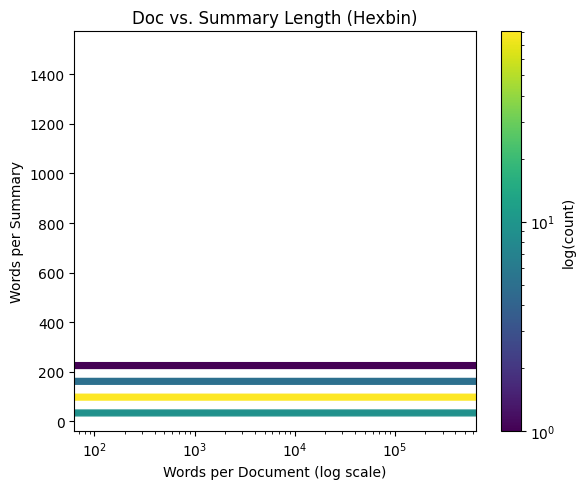

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.hexbin(df["DocWords"], df["SummaryWords"], gridsize=40, bins="log")
plt.xscale("log")
plt.xlabel("Words per Document (log scale)")
plt.ylabel("Words per Summary")
plt.title("Doc vs. Summary Length (Hexbin)")
cb = plt.colorbar()
cb.set_label("log(count)")
plt.tight_layout()
